# HK Models Comparison

- Original HK
- Random-HK **with K = num_clusters * log(N)**
- Network-HK

In [1]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
from numpy import diag
import numpy.random as rand
import random as stdrand
from numpy.linalg import norm, inv, eigvals

import sys
from IPython import display
from tqdm import tqdm
from ipyparallel import Client

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, repeat
import pandas as pd

import models
from util import *
from viz import *

#plt.rcParams['figure.figsize'] = (12.0, 9.0)
sns.set_context('paper', font_scale=1.2)

/home/user/opinions-research/env/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def list_stats(my_list):
    return '{0} values (min: {1}, max: {2})'.format(len(my_list), min(my_list), max(my_list))

In [3]:
rand.seed(4796124)
stdrand.seed(198424)
N = 625
max_rounds = 10e3

# Generate values for ε > 0.01 so that we can accurately measure cluster number
EPS_POINTS = 21
eps_list = np.linspace(0.01, 0.45, EPS_POINTS)

# Generate random opinion vectors
#s = rand.rand(N)
SIM_NUM = 100
s_list = [rand.rand(N) for _ in xrange(SIM_NUM)]

print('[+] N: {0}'.format(N))
print('[+] eps: {0}'.format(list_stats(eps_list)))
print('[+] s: {0} random values'.format(SIM_NUM))

[+] N: 625
[+] eps: 21 values (min: 0.01, max: 0.45)
[+] s: 100 random values


In [1]:
# The function that will be mapped to all values of s
def run_models(s):
    import models
    from util import cluster_count, cluster_count_net
    from numpy.linalg import norm
    import numpy as np
    
    N = len(s)
    result = tuple()
    # Original HK
    op_hk = models.hk(s, op_eps, max_rounds)
    time_hk = op_hk.shape[0]
    clusters_hk = cluster_count(op_hk[-1, :], op_eps)
    # HK Random Sampling
    k_rand = int(min(clusters_hk * np.log10(N), N * 0.1))
    op_rand = models.hk_rand(s, k_rand, op_eps, max_rounds)
    time_rand = op_rand.shape[0]
    clusters_rand = cluster_count(op_rand[-1, :], op_eps)

    cdiff_1 = abs(clusters_hk-clusters_rand)
    # Calculate differences in opinion values (2-norm)
    ndiff_1 = norm(op_hk[-1] - op_rand[-1])
    # Create result tuple
    result += (time_hk, clusters_hk)
    result += (time_rand, clusters_rand, cdiff_1, ndiff_1, k_rand)
    return result

def calculate_averages(tuple_list):
    tuple_elems = len(tuple_list[0])
    averages = np.zeros(tuple_elems)
    num_elem = len(tuple_list)
    for t in tuple_list:
        for i in xrange(tuple_elems):
            averages[i] += t[i] / num_elem
    averages = np.round(averages)
    return averages.astype(int)

In [53]:
# Initialize ipyparallel
v, dv = parallel_init('/home/user/opinions-research/', profile='ssh')

[*] 15 parallel engines available
[*] Finished setting working directories


In [61]:
# Run Models
data = np.empty((0, 7))
# res: model_id, eps, K, time, clusters, cluster_diff, norm_diff
dv.clear()  
for eps in tqdm(eps_list):
    ar = dv.push(dict(max_rounds=max_rounds, op_eps=eps))
    ar.get()
    result = parallel_map(v, run_models, s_list, silent=True)
    avg_result = calculate_averages(result)
    res_hk = np.array([0, eps, 0, avg_result[0], avg_result[1], 0, 0])
    res_rand = np.array([1, eps, avg_result[-1]])
    res_rand = np.hstack((res_rand, avg_result[2:6]))
    data = np.vstack((data, res_hk, res_rand))

In [ ]:
# Create DataFrame
df = pd.DataFrame(data=data, columns=['model_id', 'eps', 'K', 'rounds', 'clusters', 'cluster_diff', 'norm_diff'])
# Convert column types
df['K'] = df['K'].astype(int)
df['model_id'] = df['model_id'].astype(int)
df['model'] = 'hk'
df.loc[df['model_id'] == 1, 'model'] = 'sampling'
df.loc[df['model_id'] == 2, 'model'] = 'graph'

In [56]:
# Create 'eps_range' column
NUM_CUTS = 6
df['eps'] = df['eps'].round(decimals=3)
eps_cut = pd.cut(df['eps'], NUM_CUTS, precision=2, right=False)
df['eps_range'] = eps_cut
#df['eps_range'] = df['eps_range'].astype('category', ordered='True')

In [57]:
df.to_csv('hk_comparisons2.csv')

In [6]:
# Read already saved DataFrame
df = pd.read_csv('hk_comparisons2.csv')
df.loc[df['model_id'] == 1, 'model'] = 'sampling'

# Comparison of Convergence Times

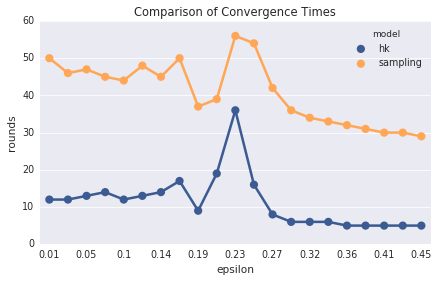

In [7]:
pal1 = sns.xkcd_palette(['denim blue', 'pale orange'])
sns.pointplot(x='eps', y='rounds', data=df[df['model'] != 'local'], hue='model', size=4, palette=pal1)
plt.ylabel('rounds')
plt.xlabel('epsilon')
plt.title('Comparison of Convergence Times')
eps_list = np.round(eps_list, decimals=2)
plt.xticks(np.arange(0, 21, 2), eps_list[0:21:2])
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.show()

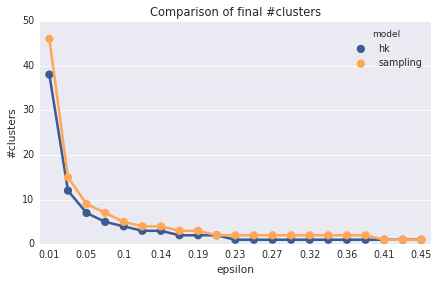

In [8]:
g = sns.pointplot(x='eps', y='clusters',hue='model', data=df[df['model'] != 'local'], palette=pal1)
plt.ylim(0, 50)
plt.xlabel('epsilon')
plt.ylabel('#clusters')
plt.title('Comparison of final #clusters')
eps_list = np.round(eps_list, decimals=2)
plt.xticks(np.arange(0, 21, 2), eps_list[0:21:2])
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.show()